Running Graphviz for node layout: neato -Tplain graph.dot -o layout.plain
Finished layout
Rendering image in 2 chunks


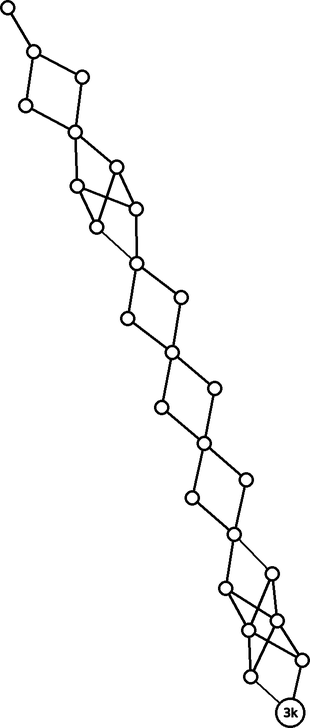

In [7]:
from PIL import Image, ImageDraw, ImageFont, ImageOps, ImageChops
import networkx as nx
import subprocess, math
from sklearn.neighbors import KDTree
import numpy as np 

 
gfa_file = 'anderson_promoters.gfa'

SMALL_NODE_DIAMETER = 30
LARGE_NODE_DIAMETER = 60
NODE_BORDER_WIDTH = 5
EDGE_WIDTH = 5
FG_COLOR = 'black'
BG_COLOR = 'white'
PALETTE = ['green']

FONT = ImageFont.truetype("/System/Library/Fonts/Menlo.ttc", 
                          size=int(LARGE_NODE_DIAMETER*0.4))


# Function to parse the GFA file
def parse_gfa(file_path, closed_graph=True):
    graph = nx.DiGraph()  # Directed graph
    walks = {}

    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith('S'):
                parts = line.strip().split('\t')
                node_id = parts[1]
                sequence = parts[2]  # Extract the sequence
                graph.add_node(node_id, seq_length = len(sequence), paths=[])
            elif line.startswith('L'):
                parts = line.strip().split('\t')
                from_node = parts[1]
                to_node = parts[3]
                graph.add_edge(from_node, to_node, paths=[])
            elif line.startswith('W'):
                parts = line.strip().split('\t')
                walks[parts[1]] = parts[6].lstrip(">").split(">")

    # Store the walks as node and edge attributes (nodes alone would probably be sufficient)
    for name, path in walks.items():
        for node in path:
            graph.nodes[node]['paths'].append(name)
        path_edges = list(zip(path, path[1:])) #+ [(highlight_nodes[-1], highlight_nodes[0])]
        for (from_node, to_node) in path_edges:
            graph.edges[(from_node,to_node)]['paths'].append(name)

    if closed_graph:
        # Connect nodes without outgoing edges to nodes without incoming edges
        nodes_without_incoming = {node for node in graph.nodes if graph.in_degree(node) == 0}
        nodes_without_outgoing = {node for node in graph.nodes if graph.out_degree(node) == 0}
    
        for node in nodes_without_outgoing:
            for target in nodes_without_incoming:
                if node != target:
                    graph.add_edge(node, target)
                    
    return graph, walks


# Function to generate the layout using Graphviz's sfdp
def generate_layout(graph, output_dot='graph.dot', layout_file='layout.plain', min_distance=SMALL_NODE_DIAMETER, rescale=True):
    # Write the graph to a .dot file
    nx.drawing.nx_agraph.write_dot(graph, output_dot)
    
    # Run sfdp to get the layout
    #command = ['sfdp', '-Tplain', output_dot, '-o', layout_file, '-Goverlap=scalexy']
    command = ['neato', '-Tplain', output_dot, '-o', layout_file]
    #command = ['sfdp', '-Tplain', output_dot, '-o', layout_file]

    print("Running Graphviz for node layout: " + " ".join(command))
    subprocess.run(command, check=True)
    print("Finished layout")

    #subprocess.run(['sfdp', '-Tplain', output_dot, '-o', layout_file, '-Gk=0.3', '-Gsep=+8', '-Goverlap=scale'], check=True)
    #subprocess.run(['sfdp', '-Tplain', output_dot, '-o', layout_file], check=True)

    # Parse the plain layout file
    node_positions = {}
    with open(layout_file, 'r') as file:
        for line in file:
            if line.startswith('node'):
                parts = line.strip().split(' ')
                node_id = parts[1]
                x, y = float(parts[2]), float(parts[3])
                node_positions[node_id] = (x, y)

    if rescale:
        # Scale the positions so that all nodes are spaced out appropriately

        ## First find the nearest neighbor for each node
        positions = list(node_positions.values())
        kd_tree = KDTree(positions)
        nearest_neighbor_distances = [d[1] for d in kd_tree.query(positions, k=2)[0]] # k=1 is the node itself
        # Make sure that at least the small nodes don't overlap with each other
        prescale_factor = int(min_distance/ min(nearest_neighbor_distances))
        scaled_node_positions =  {node: (x * prescale_factor, y * prescale_factor) for node, (x, y) in node_positions.items()}
    
        return scaled_node_positions
    else:
        return node_positions

# Implementation of Cohen-Sutherland clipping algorithm to see which edges are visible from the viewport:
#    1) Function to compute the region code for a point
def compute_outcode(x, y, rect_min, rect_max):
    xmin, ymin = rect_min
    xmax, ymax = rect_max
    code = 0 # INSIDE
    if x < xmin: code |= 1 # LEFT
    elif x > xmax: code |= 2 # RIGHT
    if y < ymin: code |= 4 # BOTTOM
    elif y > ymax: code |= 8 # TOP
    return code

#  2) Cohen-Sutherland clipping function
def cohen_sutherland_clip(p1, p2, rect_min, rect_max):
    x1, y1 = p1
    x2, y2 = p2
    outcode1 = compute_outcode(x1, y1, rect_min, rect_max)
    outcode2 = compute_outcode(x2, y2, rect_min, rect_max)
    while True:
        if not (outcode1 | outcode2):
            # Line is totally within the clip area
            return (x1, y1), (x2, y2)
        if outcode1 & outcode2:
            # Line segment outside the clip area
            return None
        
        outcode_out = outcode1 if outcode1 else outcode2

        if outcode_out & 8: # TOP
            x = x1 + (x2 - x1) * (rect_max[1] - y1) / (y2 - y1)
            y = rect_max[1]
        elif outcode_out & 4: # BOTTOM
            x = x1 + (x2 - x1) * (rect_min[1] - y1) / (y2 - y1)
            y = rect_min[1]
        elif outcode_out & 2: # RIGHT
            x = rect_max[0]
            y = y1 + (y2 - y1) * (rect_max[0] - x1) / (x2 - x1)
        elif outcode_out & 1: # LEFT
            x = rect_min[0]
            y = y1 + (y2 - y1) * (rect_min[0] - x1) / (x2 - x1)

        if outcode_out == outcode1: 
            x1, y1 = x, y
            outcode1 = compute_outcode(x, y, rect_min, rect_max)
        else: 
            x2, y2 = x, y
            outcode2 = compute_outcode(x, y, rect_min, rect_max)

def is_overlapping(image, text_bbox):
    """
    Check if the bounding box of the text overlaps with any non-white pixels.
    """
    pixels = np.array(image)
    x1, y1, x2, y2 = map(int, text_bbox)  # Ensure integers for slicing
    region = pixels[y1:y2, x1:x2]
    return np.any(np.all(region != [255, 255, 255], axis=-1))
     
def find_valid_position(image, center, radius, text, font, angle_step=5):
    """
    Find the first valid position where the bounding box of the text does not contain any non-white pixels.
    Increase the radius if no valid position is found, ensuring no overlap occurs.
    """
    draw = ImageDraw.Draw(image)
    current_radius = radius
    start_angle = 315  

    while True:
        # Check all angles at the current radius
        for angle in range(start_angle, start_angle + 360, angle_step):
            rad_angle = math.radians(angle)
            text_x = center[0] + current_radius * math.cos(rad_angle)
            text_y = center[1] + current_radius * math.sin(rad_angle)

            # Calculate the bounding box of the text
            (text_left, text_top, text_right, text_bottom) = draw.textbbox((text_x, text_y), text, font=font, anchor="mm")
            # Add some padding
            padding = (text_top - text_bottom)*0.2
            text_bbox = (text_left-padding, text_top+padding, text_right+padding, text_bottom-padding)
            # Check if the bounding box overlaps any non-white pixels
            if not is_overlapping(image, text_bbox):
                return (text_x, text_y)  # Return the valid position

        # Increase the radius and retry if no valid position is found
        current_radius += 10
        print('expanding radius')

def render_chunks(graph, node_positions, highlight_path=None, chunk_size=1000, overlap=100):
    chunks = {}
    
    max_x = max(pos[0] for pos in node_positions.values())
    max_y = max(pos[1] for pos in node_positions.values())
    
    num_chunks_x = int(max_x // chunk_size) + 1
    num_chunks_y = int(max_y // chunk_size) + 1
    
    print(f"Rendering image in {num_chunks_x * num_chunks_y} chunks")

    # TODO: parallelise this
    for i in range(num_chunks_x):
        for j in range(num_chunks_y):
            left = max(i * chunk_size - overlap, 0)
            upper = max(j * chunk_size - overlap, 0)
            right = left + chunk_size + (overlap if i==0 else 2*overlap)
            lower = upper + chunk_size + (overlap if j==0 else 2*overlap)
            
            chunk_img = Image.new('RGB', (right-left, lower-upper), BG_COLOR)
            draw = ImageDraw.Draw(chunk_img)
            
            # Draw edges first
            for edge in graph.edges:
                from_node, to_node = edge
                # Clip the line segment to the viewport
                clipped_segment = cohen_sutherland_clip(
                                    node_positions[from_node], 
                                    node_positions[to_node], 
                                    (left, upper), 
                                    (right,lower))
                
                # Skip this edge if it is outside the viewport entirely
                if clipped_segment is None: continue

                # Translate the coordinates to the viewport's frame of reference
                (x1, y1), (x2, y2) = clipped_segment
                x1 -= left
                x2 -= left
                y1 -= upper
                y2 -= upper
                
                if highlight_path in graph.edges[edge].get('paths', []):
                    draw.line(((x1, y1), (x2, y2)), fill='green', width=EDGE_WIDTH+1)
                else:
                    draw.line(((x1, y1), (x2, y2)), fill=FG_COLOR, width=EDGE_WIDTH)
            
            # Draw nodes and labels
            for node, (x, y) in node_positions.items():
                node_diameter = SMALL_NODE_DIAMETER if graph.nodes[node]['seq_length'] < 1000 else LARGE_NODE_DIAMETER
                node_radius = node_diameter / 2
                if (left - node_radius <= x <= right + node_radius) and (upper - node_radius <= y <= lower + node_radius):
                    if highlight_path in graph.nodes[node].get('paths',[]):
                        draw.ellipse([(x - left - node_radius, y - upper - node_radius),
                                      (x - left + node_radius, y - upper + node_radius)], 
                                      outline='darkgreen', 
                                      fill='lightgreen', 
                                      width=NODE_BORDER_WIDTH+1)
                    else:                    
                        draw.ellipse([(x - left - node_radius, y - upper - node_radius),
                                  (x - left + node_radius, y - upper + node_radius)], 
                                  outline=FG_COLOR, 
                                  fill=BG_COLOR, width=NODE_BORDER_WIDTH)
                    
                    # If the node is larger (diameter 50), add a label showing the length rounded to nearest thousand
                    if node_diameter > SMALL_NODE_DIAMETER:
                        seq_length = graph.nodes[node]['seq_length']
                        rounded_label = f"{round(seq_length / 1000)}k"
                        draw.text((x - left, y - upper), rounded_label, 
                                  fill=FG_COLOR, anchor="mm", 
                                  font=FONT, stroke_width=1, stroke_fill="black" )
                        
            # Do a second pass for highlights  
            for node, (x, y) in node_positions.items():
                node_diameter = SMALL_NODE_DIAMETER if graph.nodes[node]['seq_length'] < 1000 else LARGE_NODE_DIAMETER
                node_radius = node_diameter / 2
                # If the node should be highlighted, draw a larger circle around it
                if graph.nodes[node].get('highlight', False):
                    spacing = 15
                    draw.ellipse([(x - left - node_radius - spacing, y - upper - node_radius - spacing),
                                    (x - left + node_radius + spacing, y - upper + node_radius + spacing)], 
                                    outline='blue', 
                                    fill=None, width=NODE_BORDER_WIDTH)
                        
                # External label
                label = graph.nodes[node].get('label_ext', None)
                if label:
                    spacing = 45
                    best_position = find_valid_position(chunk_img, (x-left, y-upper), 
                                                        node_radius + spacing, label, FONT)
                    if not best_position:
                        print(f"Error: Could not place label at node {node}")
                    else:
                        draw.text(best_position, label, font=FONT, fill='blue', anchor="mm")
                        # # Draw a line from the highlight circle to the textbox
                        # # First convert from cartesian to polar coordinates
                        # x1, y1 = x - left, y - upper
                        # x2, y2 = best_position
                        # length = math.sqrt((x2-x1)**2 + (y2-y1)**2)
                        # angle = math.atan2(y2-y1, x2-x1)
                        # # And convert back
                        # x3 = x1 + (node_radius + spacing*2 ) * math.cos(angle)
                        # y3 = y1 + (node_radius + spacing*2 ) * math.sin(angle)
                        # x4 = x1 + (length - spacing) * math.cos(angle) # reusing spacing here, but this time we're talking about the textbox
                        # y4 = y1 + (length - spacing) * math.sin(angle)
                        # draw.line(((x3, y3),(x4, y4)), fill='blue', width=NODE_BORDER_WIDTH)

    
            # Crop the image to remove the overlaps
            if i == 0 and j == 0:
                chunk_img = chunk_img.crop((0, 0, chunk_size, chunk_size))
            elif j == 0:
                chunk_img = chunk_img.crop((overlap, 0, chunk_size+overlap, chunk_size))
            elif i == 0:
                chunk_img = chunk_img.crop((0, overlap, chunk_size, chunk_size+overlap))
            else:
                chunk_img = chunk_img.crop((overlap, overlap, chunk_size+overlap, chunk_size+overlap))

            chunks[(i,j)] = chunk_img
    
    return chunks

# Function to stitch the chunks together to form a composite image
def stitch_chunks(chunks, chunk_size=1000):
    num_chunks_x = max(i for i,_ in chunks.keys()) + 1
    num_chunks_y = max(j for _,j in chunks.keys()) + 1

    final_image = Image.new('RGB', (num_chunks_x * chunk_size,
                                   num_chunks_y * chunk_size),
                            BG_COLOR)
    
    for i in range(num_chunks_x):
        for j in range(num_chunks_y):
            chunk = chunks[(i,j)]
            left = i * chunk_size
            upper = j * chunk_size
            final_image.paste(chunk, (left, upper))
    
    return final_image

def render_image(graph, node_positions, highlight_path = None, chunk_size=1000, chunk_overlap=LARGE_NODE_DIAMETER, scaledown_factor = 2):
    # Render the image in chunks
    chunks = render_chunks(graph, node_positions, 
                       highlight_path = highlight_path,
                       chunk_size = chunk_size, 
                       overlap = chunk_overlap)

    # Stitch the chunks together
    composite = stitch_chunks(chunks, chunk_size)

    # Crop to just the figure
    # First substract the background color
    diff = ImageChops.difference(composite, 
                                Image.new(composite.mode,
                                    composite.size, 
                                    BG_COLOR))
    # Then crop to the bounding box (if it exists)
    bbox = diff.getbbox()
    if bbox:
        composite = composite.crop(bbox)

    # Scale and apply anti-alliasing
    if scaledown_factor > 1:
        composite = composite.resize((composite.width // scaledown_factor, composite.height // scaledown_factor), 
                        resample= Image.Resampling.LANCZOS)

    return composite

# Find in which node a coordinate on a path is contained
def translate_coordinate(graph, path, x):
    tally = 0
    for node in graph:
        tally += graph.nodes[node]['seq_length']
        if tally >= x:
            return node
        

# Parse the GFA file with sequence lengths for labels
graph, walks = parse_gfa(gfa_file, closed_graph=False)

# Generate layout for the graph
node_positions = generate_layout(graph, min_distance=LARGE_NODE_DIAMETER)

# Calculate where to put overall length markers using a reference path
reference_path = None
if reference_path:
    reference_length = sum([graph.nodes[node]['seq_length'] for node in walks[reference_path]])

    # Create a range of 10 values between 0 and the reference length
    x_range = np.linspace(0, reference_length, 10, endpoint=False)

    # Highlight the corresponding nodes:
    marker_nodes = [translate_coordinate(graph, reference_path, x) for x in x_range]
    for i, node in enumerate(marker_nodes):
        graph.nodes[node]['highlight'] = True
        graph.nodes[node]['label_ext'] = f"{i*10}%"


# Render the image
composite = render_image(graph, node_positions, highlight_path  = reference_path, chunk_overlap=int(LARGE_NODE_DIAMETER*1.2))

# Save the final composite image
#composite.save('final_composite.png')

#composite.show() # Open in Preview
display(composite)


